Part I:

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [df]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.


<Axes: title={'center': 'x'}>

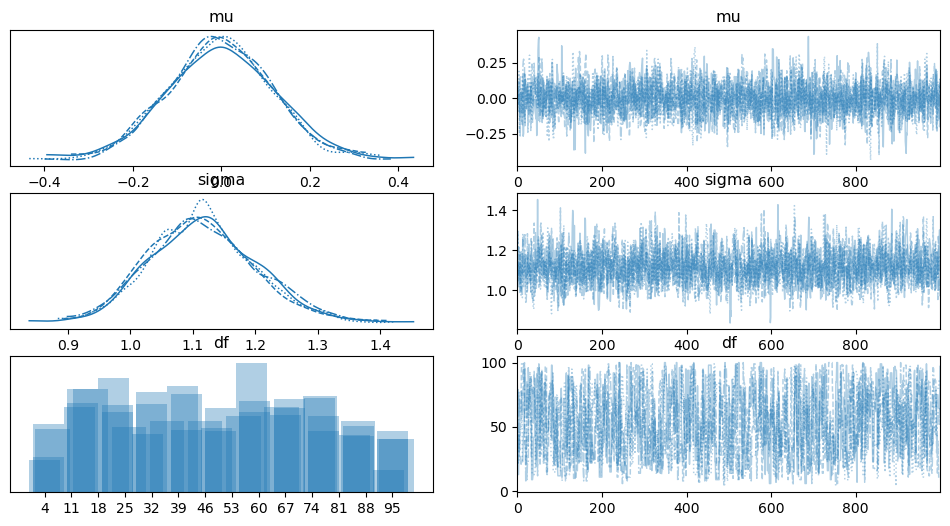

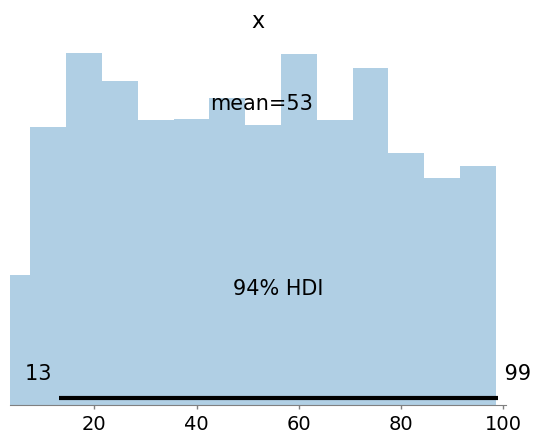

In [1]:
# Name: Laijun Xu


import pymc as pm
import arviz as az
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# Assumed true values for generating synthetic data
n = 100
loc_true = 0
scale_true = 1
df_true = 30  # Degrees of freedom

# Generate synthetic data
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)

with pm.Model() as model:
    # Define prior distributions
    mu = pm.Normal('mu', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=5)
    df = pm.DiscreteUniform('df', lower=1, upper=100)

    # Define the likelihood function
    likelihood = pm.StudentT('y', mu=mu, sigma=sigma, nu=df, observed=x)

    # Perform HMC sampling
    trace = pm.sample(1000, tune=500, target_accept=0.95, return_inferencedata=True)

# Posterior analysis
summary = az.summary(trace, var_names=['mu', 'sigma', 'df'])
az.plot_trace(trace, var_names=['mu', 'sigma', 'df'])

# Extract the samples for df, ensuring we handle the returned object type correctly
df_samples = trace.posterior['df'].values.flatten()
az.plot_posterior(df_samples)



Part II:

In [2]:
import numpy as np
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])


with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
    

SEED = [20100420, 20134234] # random seeds for each of two run HMC chains
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})
     
        
with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations
    # below so the energy still has high curvature with respect to tau; but,
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
     
                
with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta_t]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


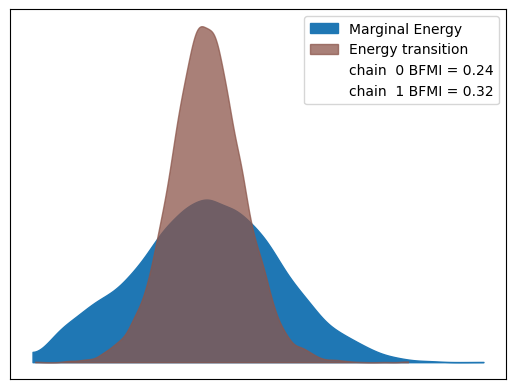

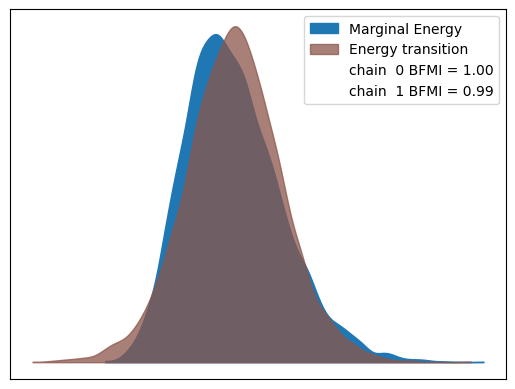

In [3]:
import arviz as az
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

Based on the energy plots for the "centered" and "uncentered" models, we can draw several conclusions about the performance of the Hamiltonian Monte Carlo (HMC) algorithm for these parameterizations:

For the "centered" model, as indicated by the top plot, the lower BFMI values signal a potential mismatch between the energy transition distribution and the marginal energy distribution. Such low BFMI values often reflect sampling inefficiencies, suggesting that the sampler may encounter difficulties effectively navigating the posterior landscape. This could be due to the parameterization leading to regions in the posterior distribution with high curvature, which can create challenges for the HMC algorithm.

In contrast, the "uncentered" model depicted in the bottom plot shows BFMI values close to the ideal of 1. This suggests a good alignment between the energy transitions and the overall energy distribution, implying that the sampler can more reliably explore the posterior. The "uncentered" approach likely reduces complex geometric features in the posterior, such as high curvature areas, which facilitates more efficient sampling.

The comparison of these two plots supports the idea that "uncentering" the model can significantly enhance the HMC algorithm's performance. It appears to smooth out the energy function landscape, allowing for more straightforward navigation and fewer transitions between markedly different energy levels. Consequently, the "uncentered" model provides a more robust framework for the HMC sampler to generate high-quality samples from the posterior distribution, which aligns with our previous discussions on the benefits of such a parameterization approach in HMC sampling.